In [1]:
import sys
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from random import seed as r_seed
from random import randint

from numpy.random import choice
from numpy.random import seed

from keras.datasets import mnist
%matplotlib inline

In [2]:
# Load data

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [55]:
# Separate we are going to use 1 and 2

# for test sake we are going to use only 10 samples

x_filtered_1=x_train[y_train[:]==1, :, :]
x_filtered_2=x_train[y_train[:]==2, :, :]
x_filtered = np.vstack((x_filtered_1[0:1500], x_filtered_2[0:1500,:,:]))

x_validation = np.vstack((x_filtered_1[1501:2000], x_filtered_2[1501:2000,:,:]))



y_filtered_1 = y_train[y_train[:]==1]
y_train_1 = y_filtered_1[0:1500]


y_filtered_2 = y_train[y_train[:]==2]
y_train_2 = y_filtered_2[0:1500]


y_validation_1 = y_filtered_1[1501:2001]
y_validation_2 = y_filtered_2[1501:2001]


y_filtered = np.append(y_train_1,y_train_2)

y_validation = np.append(y_validation_1,y_validation_2)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


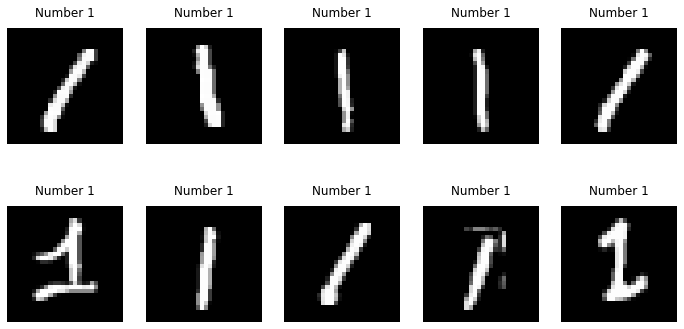

In [120]:
# just to check
# EDA

fig, axs = plt.subplots(2, 5, figsize = (12, 6))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(x_filtered[i])
    ax.axis("off")
    ax.set_title("Number {}".format(y_filtered[i]))

fig.show()

In [106]:

# Correlation will be my distance measure
def pearson_r(x, y):
    # Compute correlation matrix
    corr_mat = np.corrcoef(x, y)
    # Return entry [0,1]
    return corr_mat[0,1]


# Return the numpy array with the fit spline values
def get_spline_d3(digit, index_list):
    x_y = list()
    x_points = list()
    y_points = list()
    
    for i in index_list:
        x_y.append([i,-np.argmax(digit[i], axis=0)])
    
    sorted_by_first = sorted(x_y, key=lambda tup: tup[0])   

    for i in sorted_by_first:
        x_points.append(i[0])
        y_points.append(i[1])

    x = np.asarray(x_points)
    y = np.asarray(y_points)
    
    cs = CubicSpline(x, y)
    xs = np.arange(0, 28, 0.1)
    
    return cs(xs, 3)
    

# Return the numpy array with the fit spline values
def get_spline(digit, index_list):
    x_y = list()
    x_points = list()
    y_points = list()
    
    for i in index_list:
        x_y.append([i,-np.argmax(digit[i], axis=0)])
    
    sorted_by_first = sorted(x_y, key=lambda tup: tup[0])   

    for i in sorted_by_first:
        x_points.append(i[0])
        y_points.append(i[1])

    x = np.asarray(x_points)
    y = np.asarray(y_points)
    
    cs = CubicSpline(x, y)
    xs = np.arange(0, 28, 0.1)
    
    return cs(xs)


# return the dissimilarity matrix
# columns represents meoids
def compute_distance(digits, meoids):
    meoids_row, meoids_col = meoids.shape
    digits_row, digits_col = digits.shape
    
    dissimilarity_matrix = np.zeros((digits_row,meoids_row))
    
    current_meoid=0
    current_digit=0
    
    for meoid in meoids:
        for digit in digits:
            dissimilarity_matrix[current_digit][current_meoid] = pearson_r(meoid,digit)
            current_digit+=1
            
        current_meoid+=1
        current_digit = 0
    
    return dissimilarity_matrix**2



# assing
def assing_cluster(dissimilarity_matrix):
    return np.argmax(dissimilarity_matrix, axis=1)
    
    
    
def update_meoids(digits, meoids, dissimilarity_matrix):
    labeled_data = assing_cluster(dissimilarity_matrix)
    meoids_row, meoids_col = meoids.shape
    
    
    new_meoids = meoids.copy()
    temp_meoids = meoids.copy()
    
    # Calculate avg dissimilarity between meoids
    avg_dissimilarity = np.zeros((meoids_row,1))
    row_count=0
    

    for labeled_digit in labeled_data:
        avg_dissimilarity[labeled_digit]+=dissimilarity_matrix[row_count][labeled_digit]
        row_count+=1
    
    
    # Calculate new meoid
    meoid_count=0
    digit_count=0
    
    current_avg=0
    new_avg=0
    
    
    
    
    for meoid in meoids:
        # Separate data by cluster to posterior calculation
        current_cluster = digits[labeled_data[:]==meoid_count, :]
        
        print(current_cluster.shape)

        current_avg = avg_dissimilarity[meoid_count]
        
        for digit in current_cluster:
            temp_meoids[meoid_count]=digit
            temp_matrix_dissimilarity = compute_distance(digits,temp_meoids)
            temp_labeled_data = assing_cluster(temp_matrix_dissimilarity)
            
            new_avg = np.sum(temp_labeled_data[temp_labeled_data[:]==meoid_count])
            
            # We are using correlation for that reason we want a maximum
            if current_avg <= new_avg:
                current_avg = new_avg
                new_meoids[meoid_count] = digit
            
            digit_count+=1
        temp_meoids=new_meoids.copy()
        
        meoid_count += 1
        digit_count = 0
        
    return new_meoids
    
    
        
    
def has_converged(old_meoids, new_meoids):
    meoid_count=0
    if old_meoids is None:
        return False
    for meoid in old_meoids:
        if(meoid.all() != new_meoids[meoid_count].all()):
            return False
    return True
    
    
# k is the meoids number
def init_meoids(digits, k):
    row,col=digits.shape
    seed(1)
    samples = choice(row, size=k, replace=False)
    return digits[samples,:]

# k is the meoids number
def init_meoids_2(digits):
    row,col=digits.shape
    samples = np.zeros((2,col))
    two=row//2+1
    
    samples[0] = digits[0,:]
    samples[1] = digits[two,:]
    
    return samples

# k is the meoids number
def init_meoids_3(digits,k):
    row,col=digits.shape   
    seed(1)
    samples = choice(row//k-1, size=k, replace=False)
    
    samples[1]=samples[1]+(row//k-1)
    
    return digits[samples,:]


In [107]:
def k_meoids(data, k, max_iterations=np.inf):
    
    data_dim, data_row, data_col=data.shape
    
    # get common knots
    seed(1)
    index_list=list()

    for i in range(8):
        r_number = randint(0, data_col-1)
        if r_number not in index_list:
            index_list.append(r_number)
             
                
    # get the splines of all digits
    digits_list=list()
    for dig in data:
        digits_list.append(get_spline_d3(dig,index_list))
       
    # all the data fit to a spline is in this array
    digits = np.asmatrix(digits_list)
    
    # init meoids
    meoids = init_meoids_3(digits,k)
    
    dissimilarity_matrix=compute_distance(digits,meoids)
    
    iteration = 0
    old_meoids=None
    converged = False
    
    while converged==False:
        old_meoids = meoids.copy()
        meoids = update_meoids(digits,old_meoids,dissimilarity_matrix)
        dissimilarity_matrix = compute_distance(digits,meoids)
        
        
        converged = has_converged(old_meoids, meoids)
        if converged == False and iteration == max_iterations:
            break
            
        iteration+=1
        
#     print("Iterations:",iteration)
    
    return meoids
        

# Classification when meoids were alredy calculated
def fit_model(data, meoids):
    data_dim, data_row, data_col = data.shape
    
    # get common knots
    seed(1)
    index_list=list()

    for i in range(8):
        r_number = randint(0, data_col-1)
        if r_number not in index_list:
            index_list.append(r_number)
             
                
    # get the splines of all digits
    digits_list=list()
    for dig in data:
        digits_list.append(get_spline_d3(dig, index_list))
       
    # all the data fit to a spline is in this array
    digits = np.asmatrix(digits_list)
    
    dissimilarity_matrix=compute_distance(digits,meoids)
    y_pred = assing_cluster(dissimilarity_matrix)
    y_pred += 1
    
    return y_pred



def measure_accuracy(y,y_pred):
    diff = np.sum(y - y_pred)
    n=y.shape
    print("Diff = ",diff)
    print("Accuracy of prediction = ",((n - diff)/n)*100)

    

In [108]:
meoids = k_meoids(x_filtered, 2)

y_pred = fit_model(x_validation,meoids)
measure_accuracy(y_validation, y_pred)

(2192, 280)
(808, 280)
Iterations: 1
Diff =  -103
Accuracy of prediction =  [110.32064128]


In [109]:
measure_accuracy(y_pred,y_validation)

Diff =  103
Accuracy of prediction =  [89.67935872]


In [111]:
y_pred = fit_model(x_validation,meoids)
measure_accuracy(y_validation, y_pred)


measure_accuracy(y_pred,y_validation)

Diff =  -381
Accuracy of prediction =  [138.17635271]
Diff =  381
Accuracy of prediction =  [61.82364729]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


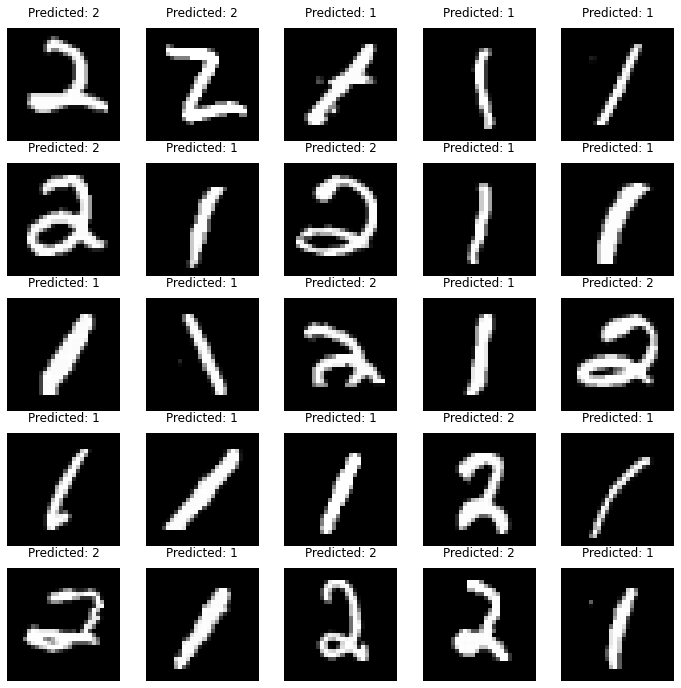

In [119]:
seed(1)
samples = choice(1000, size=25, replace=False)

x_graph=x_validation[samples,:,:]
y_graph=y_validation[samples]



fig, axs = plt.subplots(5,5, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(x_graph[i])
    ax.axis("off")
    ax.set_title("Predicted: {}".format(y_graph[i]))

fig.show()